# Lab 2: Probability, Statistics & Significance in Bioinformatics

This notebook follows the 90-minute lab exercises: from sampling and t-tests to BH FDR, bootstrapping, and a short Bayesian demo. The notebook will attempt to download a small RNA-seq dataset from GEO; if that fails (no internet / package), it will simulate a dataset.

**Environment:** Python, `numpy`, `pandas`, `scipy`, `statsmodels`, `matplotlib`, `seaborn`.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

sns.set_theme(style='whitegrid', context='notebook', rc={'figure.figsize':(8,5)})
np.random.seed(42)

print('Libraries imported. numpy, pandas, scipy, statsmodels, matplotlib, seaborn')

Libraries imported. numpy, pandas, scipy, statsmodels, matplotlib, seaborn


In [4]:
# Try to fetch GEO dataset; fallback to simulated if unavailable
use_real = False
try:
    import GEOparse
    print('GEOparse available. Attempting to download a small dataset (this may fail if no internet).')
    gse_id = 'GSE10072'
    try:
        gse = GEOparse.get_GEO(geo=gse_id, destdir='.')
        
        # Try to get expression data from the correct location
        if hasattr(gse, 'pivot_samples') and callable(gse.pivot_samples):
            try:
                expr_table = gse.pivot_samples('VALUE')
                if expr_table is not None and not expr_table.empty:
                    use_real = True
                    print(f'Loaded expression table from {gse_id} (shape: {expr_table.shape})')
                else:
                    print('Expression table is empty; will fallback to simulation.')
            except Exception as pivot_e:
                print(f'Failed to pivot samples: {pivot_e}')
                # Try alternative method - access through samples
                if hasattr(gse, 'samples') and gse.samples:
                    sample_data = []
                    sample_names = []
                    for sample_id, sample in gse.samples.items():
                        if hasattr(sample, 'table') and sample.table is not None:
                            sample_data.append(sample.table['VALUE'].values)
                            sample_names.append(sample_id)
                    
                    if sample_data:
                        expr_table = pd.DataFrame(sample_data).T
                        expr_table.columns = sample_names
                        use_real = True
                        print(f'Loaded expression table from {gse_id} via samples (shape: {expr_table.shape})')
                    else:
                        print('No expression data found in samples; will fallback to simulation.')
                else:
                    print('No samples found; will fallback to simulation.')
        else:
            print('GSE object does not have pivot_samples method; will fallback to simulation.')
    except Exception as e:
        print('Failed to download or parse GEO series:', e)
except Exception as e:
    print('GEOparse not available or import failed:', e)

if not use_real:
    print('Falling back to simulated RNA-seq-like dataset (Negative Binomial counts).')
    n_genes = 100
    n_ctrl = 3
    n_treat = 3
    mu = np.random.gamma(shape=2.0, scale=10.0, size=n_genes)
    dispersion = 0.2
    counts_ctrl = np.vstack([np.random.negative_binomial(n=1/dispersion, p=(1/(1+mu[i]*dispersion)), size=n_ctrl)
                              for i in range(n_genes)])
    mu_treat = mu.copy()
    de_genes = np.random.choice(n_genes, size=10, replace=False)
    mu_treat[de_genes[:5]] *= 3.0
    mu_treat[de_genes[5:]] *= 0.4
    counts_treat = np.vstack([np.random.negative_binomial(n=1/dispersion, p=(1/(1+mu_treat[i]*dispersion)), size=n_treat)
                               for i in range(n_genes)])
    counts = np.hstack([counts_ctrl, counts_treat]).astype(int)
    sample_labels = ['ctrl1','ctrl2','ctrl3','trt1','trt2','trt3']
    expr_df = pd.DataFrame(counts, columns=sample_labels)
    expr_df.index = [f'gene_{i+1}' for i in range(n_genes)]
    print('Simulated count matrix shape:', expr_df.shape)
    expr_df.head()
else:
    # Process real GEO data
    print('Using real GEO data. Processing expression matrix...')
    # Clean up the data - remove any non-numeric columns and handle missing values
    expr_df = expr_table.select_dtypes(include=[np.number])
    expr_df = expr_df.fillna(0)  # Fill missing values with 0
    
    # If we have too many genes, subsample for computational efficiency
    if expr_df.shape[0] > 1000:
        print(f'Subsampling from {expr_df.shape[0]} to 1000 genes for efficiency')
        expr_df = expr_df.sample(n=1000, random_state=42)
    
    # Create artificial treatment groups for demonstration
    # In real analysis, you would use the actual sample metadata
    n_samples = expr_df.shape[1]
    n_ctrl = n_samples // 2
    n_treat = n_samples - n_ctrl
    
    # Rename columns to match the expected format
    ctrl_cols = expr_df.columns[:n_ctrl]
    treat_cols = expr_df.columns[n_ctrl:n_ctrl+n_treat]
    
    # Rename columns for consistency with the rest of the notebook
    new_cols = ['ctrl' + str(i+1) for i in range(n_ctrl)] + ['trt' + str(i+1) for i in range(n_treat)]
    expr_df.columns = new_cols
    
    print(f'Real data matrix shape: {expr_df.shape}')
    print('Sample groups:', new_cols)
    expr_df.head()

12-Oct-2025 19:01:23 DEBUG utils - Directory . already exists. Skipping.
12-Oct-2025 19:01:23 INFO GEOparse - File already exist: using local version.
12-Oct-2025 19:01:23 INFO GEOparse - Parsing .\GSE10072_family.soft.gz: 
12-Oct-2025 19:01:23 DEBUG GEOparse - DATABASE: GeoMiame


GEOparse available. Attempting to download a small dataset (this may fail if no internet).


12-Oct-2025 19:01:23 DEBUG GEOparse - SERIES: GSE10072
12-Oct-2025 19:01:23 DEBUG GEOparse - PLATFORM: GPL96
12-Oct-2025 19:01:24 DEBUG GEOparse - SAMPLE: GSM254625
12-Oct-2025 19:01:24 DEBUG GEOparse - SAMPLE: GSM254626
12-Oct-2025 19:01:24 DEBUG GEOparse - SAMPLE: GSM254627
12-Oct-2025 19:01:24 DEBUG GEOparse - SAMPLE: GSM254628
12-Oct-2025 19:01:24 DEBUG GEOparse - SAMPLE: GSM254629
12-Oct-2025 19:01:24 DEBUG GEOparse - SAMPLE: GSM254630
12-Oct-2025 19:01:24 DEBUG GEOparse - SAMPLE: GSM254631
12-Oct-2025 19:01:24 DEBUG GEOparse - SAMPLE: GSM254632
12-Oct-2025 19:01:24 DEBUG GEOparse - SAMPLE: GSM254633
12-Oct-2025 19:01:24 DEBUG GEOparse - SAMPLE: GSM254634
12-Oct-2025 19:01:24 DEBUG GEOparse - SAMPLE: GSM254635
12-Oct-2025 19:01:24 DEBUG GEOparse - SAMPLE: GSM254636
12-Oct-2025 19:01:24 DEBUG GEOparse - SAMPLE: GSM254637
12-Oct-2025 19:01:25 DEBUG GEOparse - SAMPLE: GSM254638
12-Oct-2025 19:01:25 DEBUG GEOparse - SAMPLE: GSM254639
12-Oct-2025 19:01:25 DEBUG GEOparse - SAMPLE: GSM25

Loaded expression table from GSE10072 (shape: (22283, 107))
Using real GEO data. Processing expression matrix...
Subsampling from 22283 to 1000 genes for efficiency
Real data matrix shape: (1000, 107)
Sample groups: ['ctrl1', 'ctrl2', 'ctrl3', 'ctrl4', 'ctrl5', 'ctrl6', 'ctrl7', 'ctrl8', 'ctrl9', 'ctrl10', 'ctrl11', 'ctrl12', 'ctrl13', 'ctrl14', 'ctrl15', 'ctrl16', 'ctrl17', 'ctrl18', 'ctrl19', 'ctrl20', 'ctrl21', 'ctrl22', 'ctrl23', 'ctrl24', 'ctrl25', 'ctrl26', 'ctrl27', 'ctrl28', 'ctrl29', 'ctrl30', 'ctrl31', 'ctrl32', 'ctrl33', 'ctrl34', 'ctrl35', 'ctrl36', 'ctrl37', 'ctrl38', 'ctrl39', 'ctrl40', 'ctrl41', 'ctrl42', 'ctrl43', 'ctrl44', 'ctrl45', 'ctrl46', 'ctrl47', 'ctrl48', 'ctrl49', 'ctrl50', 'ctrl51', 'ctrl52', 'ctrl53', 'trt1', 'trt2', 'trt3', 'trt4', 'trt5', 'trt6', 'trt7', 'trt8', 'trt9', 'trt10', 'trt11', 'trt12', 'trt13', 'trt14', 'trt15', 'trt16', 'trt17', 'trt18', 'trt19', 'trt20', 'trt21', 'trt22', 'trt23', 'trt24', 'trt25', 'trt26', 'trt27', 'trt28', 'trt29', 'trt30', '

## Exercise 0 — Setup & Warm-up

Explore the dataset: view head, summary statistics, and plot histogram of expression for one gene.

Expression matrix shape: (1000, 107)


<BarContainer object of 107 artists>

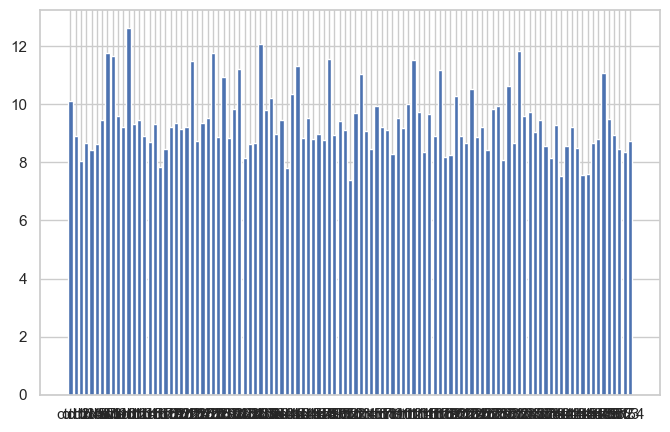

In [5]:
print('Expression matrix shape:', expr_df.shape)
expr_df.head()

expr_df.describe().T.head()

# Plot histogram of a single gene
gene = expr_df.index[0]

# Plot a histogram of gene expression
plt.bar(expr_df.columns, expr_df.loc[gene].tolist())

## Exercise 1 — Probability & Sampling

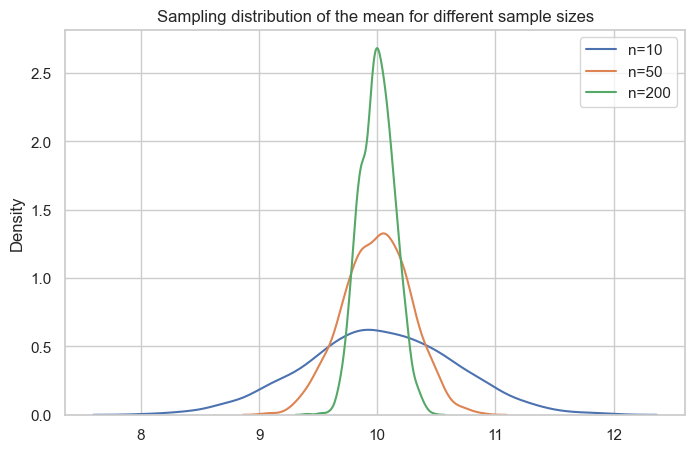

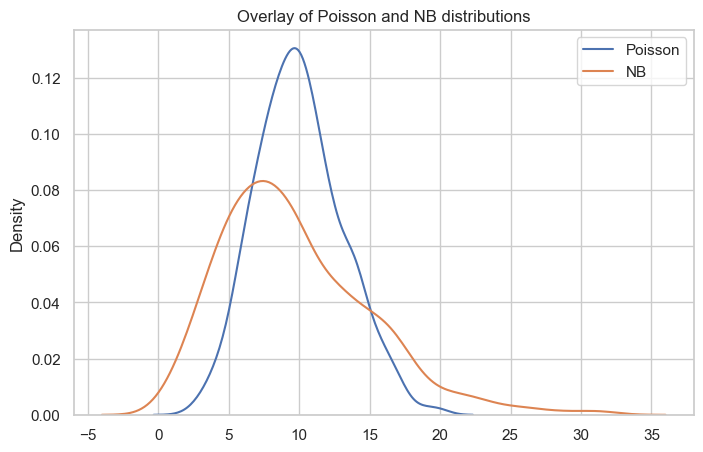

In [6]:
pop = np.random.normal(loc=10, scale=2, size=100000)
for n in [10,50,200]:
    means = [np.mean(np.random.choice(pop, size=n, replace=True)) for _ in range(2000)]
    sns.kdeplot(means, label=f'n={n}')
plt.legend()
plt.title('Sampling distribution of the mean for different sample sizes')
plt.show()

# Compare Poisson and NB
lam = 10
pois = np.random.poisson(lam, size=1000)
nb = np.random.negative_binomial(n=1/0.2, p=(1/(1+lam*0.2)), size=1000)

# plot overlay of Poisson and NB distributions
sns.kdeplot(pois, label="Poisson")
sns.kdeplot(nb, label="NB")
plt.legend()
plt.title("Overlay of Poisson and NB distributions")
plt.show()

## Exercise 2 — Hypothesis Testing: t-test

Gene: 205927_s_at, t-stat=1.728, p-value=0.0871


<Axes: title={'center': 'count'}, xlabel='[group]'>

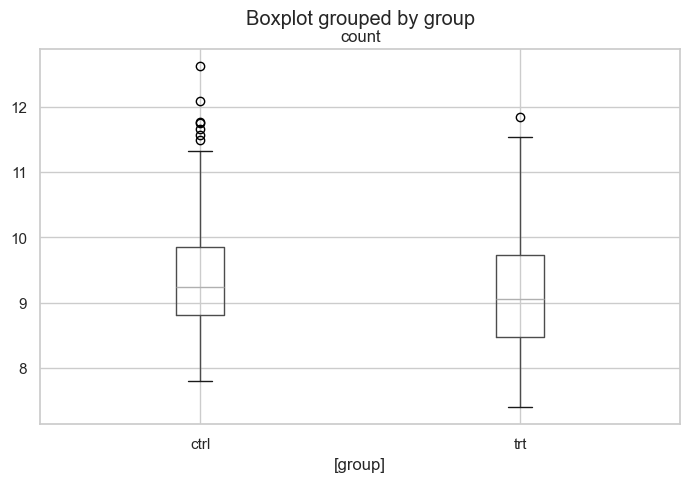

In [7]:
gene = expr_df.index[0]
ctrl = expr_df.loc[gene, expr_df.columns.str.contains('ctrl')]
trt = expr_df.loc[gene, expr_df.columns.str.contains('trt')]
tstat, pval = stats.ttest_ind(ctrl, trt, equal_var=False)
print(f'Gene: {gene}, t-stat={tstat:.3f}, p-value={pval:.3g}')

# boxplot
import pandas as pd
data = pd.DataFrame({'count': np.concatenate([ctrl.values, trt.values]),
    'group': ['ctrl']*len(ctrl) + ['trt']*len(trt)})

# plot boxplot containing both ctrl and trt groups. What does the boxplot tell you?
data.boxplot(by="group")

## Exercise 3 — ANOVA

ANOVA F-stat=22.637, p-value=5.81e-08


<Axes: title={'center': 'value'}, xlabel='[group]'>

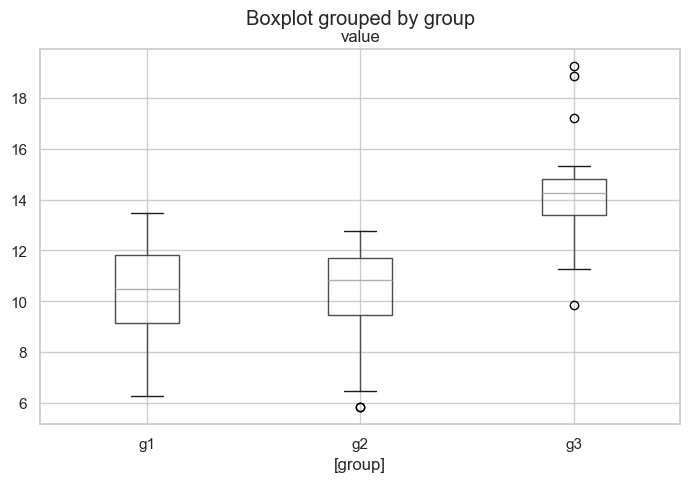

In [8]:
g1 = np.random.normal(10,2,20)
g2 = np.random.normal(11,2,20)
g3 = np.random.normal(14,2,20)
fstat, pval_anova = stats.f_oneway(g1,g2,g3)
print(f'ANOVA F-stat={fstat:.3f}, p-value={pval_anova:.3g}')

df_anova = pd.DataFrame({'value': np.concatenate([g1,g2,g3]),
    'group': ['g1']*len(g1) + ['g2']*len(g2) + ['g3']*len(g3)})
# plot boxplot containing all three groups. What does the boxplot tell you?
df_anova.boxplot(by="group")

## Exercise 4 — Multiple Testing & FDR

Raw significant (p<0.05): 104 / 1000
BH-significant (FDR<0.05): 0


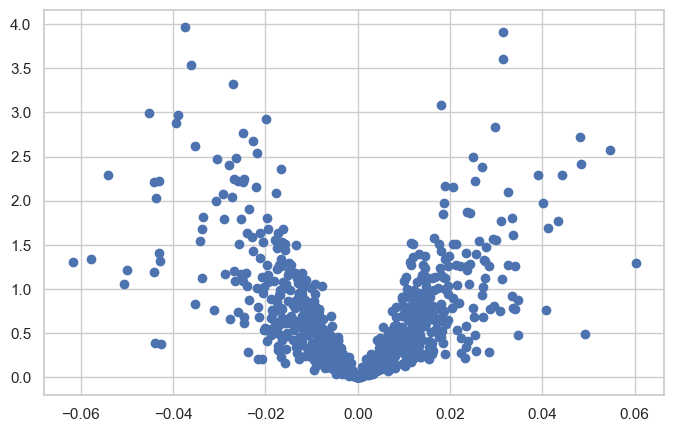

In [9]:
pvals = []
log2fc = []
# Obtain p-values and log2FC for all genes
for g in expr_df.index:
    a = expr_df.loc[g, expr_df.columns.str.contains('ctrl')].values
    b = expr_df.loc[g, expr_df.columns.str.contains('trt')].values
    t, p = stats.ttest_ind(a, b, equal_var=False)
    pvals.append(p if not np.isnan(p) else 1.0)
    log2fc.append(np.log2((b.mean()+1)/(a.mean()+1)))

pvals = np.array(pvals)
log2fc = np.array(log2fc)
rej, pvals_corrected, alphacSidak, alphacBonf = multipletests(pvals, alpha=0.05, method='fdr_bh')
print(f"Raw significant (p<0.05): {(pvals<0.05).sum()} / {len(pvals)}")
print(f"BH-significant (FDR<0.05): {rej.sum()}")

# plot volcano plot of all genes (scatter plot of log2FC vs -log10(p-value)). What does the volcano plot tell you?
plt.scatter(log2fc, -np.log10(pvals))
plt.show()

## Exercise 5 — DGE Mini-Analysis

<Axes: ylabel='ID_REF'>

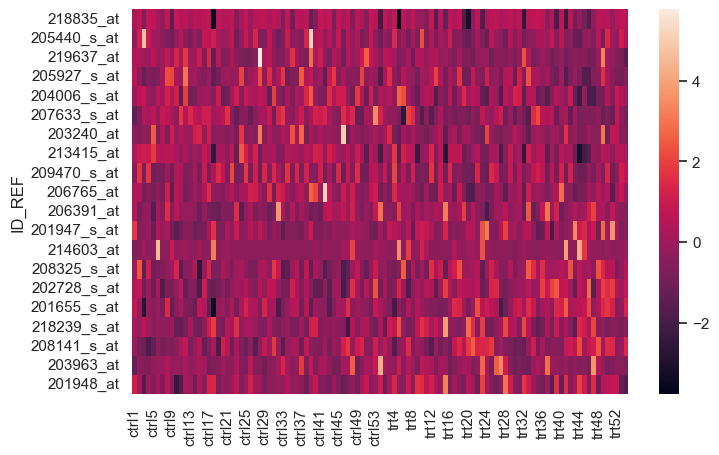

In [10]:
res = pd.DataFrame({'gene': expr_df.index, 'log2FC': log2fc, 'pval': pvals, 'pval_adj': pvals_corrected, 'significant': rej}).set_index('gene').sort_values('pval')
res.head()
import seaborn as sns

# top genes
# select top 10 upregulated and downregulated genes. What do you think about the results?
res_sorted = res.sort_values(by="log2FC")
top_up = res_sorted.tail(10).iloc[::-1]
top_down = res_sorted.head(10)

top = pd.concat([top_down, top_up])
top_genes = top.index.tolist()

# Heatmap
# plot heatmap of top candidate genes. What does the heatmap tell you?

zscore_df = expr_df.apply(stats.zscore, axis=1, result_type="broadcast").loc[top_genes]
sns.heatmap(zscore_df)

## Exercise 6 — Bootstrapping Confidence Intervals

95% conf interval: (9.175, 9.610)


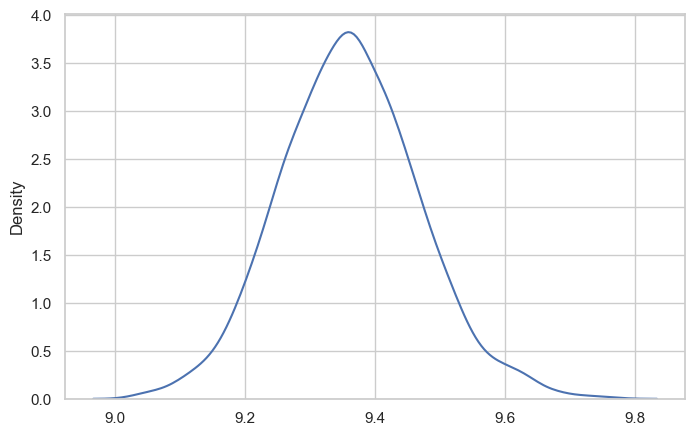

In [34]:
gene = expr_df.index[0]
values = expr_df.loc[gene].values
n_boot = 2000

# plot bootstrap distribution of mean for the first gene (sample randomly with replacement from the gene's mean expression values, and then calculate Confidence Interval [2.5,97.5]). 
bootstrap_values = stats.bootstrap((values, ), statistic=np.mean, n_resamples=n_boot)
sns.kdeplot(bootstrap_values.bootstrap_distribution)
print(f"95% conf interval: ({bootstrap_values.confidence_interval.low:.3f}, {bootstrap_values.confidence_interval.high:.3f})")

## Exercise 7 — Bayesian Inference Basics (Simple Demo)

In [ ]:
from scipy.stats import beta
# Let's say we have a coin that we know is fair (p=0.5). We flip it 6 times and get 4 heads. What is the posterior distribution of the probability of heads?
alpha_prior, beta_prior = 1, 1
successes = 4
trials = 6
# The coin toss may be biased, so we update our prior belief about the probability of heads.
# The coin toss may be modelled by a binomial distribution, which is a special case of the beta-binomial distribution.
# The beta-binomial distribution is a conjugate prior for the binomial distribution.
# The posterior distribution is given by the beta distribution.
alpha_post = alpha_prior + successes
beta_post = beta_prior + (trials - successes)
x = np.linspace(0,1,200)

# TODO plot prior and posterior distributions. What does the posterior distribution tell you?

array([0.        , 0.00502513, 0.01005025, 0.01507538, 0.0201005 ,
       0.02512563, 0.03015075, 0.03517588, 0.04020101, 0.04522613,
       0.05025126, 0.05527638, 0.06030151, 0.06532663, 0.07035176,
       0.07537688, 0.08040201, 0.08542714, 0.09045226, 0.09547739,
       0.10050251, 0.10552764, 0.11055276, 0.11557789, 0.12060302,
       0.12562814, 0.13065327, 0.13567839, 0.14070352, 0.14572864,
       0.15075377, 0.15577889, 0.16080402, 0.16582915, 0.17085427,
       0.1758794 , 0.18090452, 0.18592965, 0.19095477, 0.1959799 ,
       0.20100503, 0.20603015, 0.21105528, 0.2160804 , 0.22110553,
       0.22613065, 0.23115578, 0.2361809 , 0.24120603, 0.24623116,
       0.25125628, 0.25628141, 0.26130653, 0.26633166, 0.27135678,
       0.27638191, 0.28140704, 0.28643216, 0.29145729, 0.29648241,
       0.30150754, 0.30653266, 0.31155779, 0.31658291, 0.32160804,
       0.32663317, 0.33165829, 0.33668342, 0.34170854, 0.34673367,
       0.35175879, 0.35678392, 0.36180905, 0.36683417, 0.37185

## Exercise 8 — Model Confidence in ML (Optional)

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Demonstration of a simple model confidence interval

X = expr_df.T.mean(axis=1).values.reshape(-1,1)
y = np.array([0]*3 + [1]*3)
accs = []
for _ in range(200):
    idx = np.random.choice(len(y), size=len(y), replace=True)
    Xb, yb = X[idx], y[idx]
    if len(set(yb)) == 1: continue
    clf = LogisticRegression().fit(Xb, yb)
    preds = clf.predict(Xb)
    accs.append(accuracy_score(yb, preds))
np.percentile(accs, [2.5,50,97.5])

array([0.66666667, 0.66666667, 1.        ])